# Paris Saclay Center for Data Science : prédiction du nombre de passagers aériens

## Introduction
L'ensemble de données nous a été donné par une société anonyme qui s'occupe de la réservation des billets d'avion. Les données sont "maigres", mais elles contiennent : 

- la date de départ
- l'aéroport de départ
- l'aéroport d'arrivée
- la moyenne et l'écart-type du nombre de semaines des réservations effectuées avant la date de départ
- un champ appelé `log_PAX` qui est lié au nombre de passagers (le nombre réel a été modifié pour des raisons de confidentialité)

L'objectif est de prédire la colonne `log_PAX`. La qualité de la prédiction est mesurée par RMSE.

Les données sont évidemment limitées, mais comme les données et les informations de localisation sont disponibles, elles peuvent être jointes à des données externes. Le défi de ce RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien.

In [318]:
import os
from distance_calcul import distance
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from describe import stats_histo
import problem
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## Chargement des données

Les données relatives à la formation et aux tests se trouvent dans le dossier `data`. Elles sont compressées dans un fichier `csv` (c'est-à-dire `csv.bz2`). Nous pouvons charger l'ensemble de données en utilisant des pandas.

In [319]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [320]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


La colonne `log_PAX` est la cible de notre problème de régression. Les autres colonnes sont les caractéristiques qui seront utilisées pour la prédiction.

`Departure` et `Arrival` sont le code de l'aéroport. Toutefois, nous voyons que la `DateOfDeparture` devrait être une date au lieu d'une chaîne de caractères. Nous pouvons utiliser des pandas pour convertir ces données.

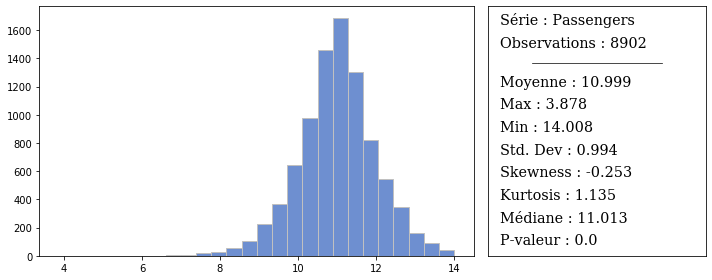

In [4]:
stats_histo(y_train, 'Passengers')

## Préprocessing

### Transformeurs : préprocessing des dates

La mise en colonnes numériques des dates est une opération courante lorsque les données des séries chronologiques sont analysées à l'aide de prédicteurs non paramétriques. Le code ci-dessous permet d'effectuer les transformations suivantes :

- colonnes numériques pour l'année (2011-2012) 
- le mois (1-12) 
- le jour du mois (1-31),
- le jour de la semaine (0-6) 
- la semaine de l'année (1-52)

In [228]:
def parse_date(x):
    date = pd.to_datetime(x, format="%Y-%m-%d")
    return pd.Series([date.year, date.month, date.day, date.weekday(), date.week])

Nous effectuerons toutes les étapes de prétraitement dans le cadre d'une `pipeline` scikit-learn qui enchaîne les étapes de transformation et d'estimation. 

Cette méthode est pratique et sûre (elle permet d'éviter les fuites de statistiques de vos données de test dans le modèle formé lors de la validation croisée). De plus, l'ensemble du pipeline peut être évalué avec `cross_val_score`.

Pour effectuer le codage ci-dessus dans un pipeline scikit-learn, nous allons créer une fonction et utiliser `FunctionTransformer` pour la rendre compatible avec l'API scikit-learn.

In [229]:
from sklearn.preprocessing import FunctionTransformer

def _encoder_dates(X):
    X[["year","month","day","weekday","week"]] = X[
    "DateOfDeparture"].apply(parse_date)
    return X.drop(columns=["DateOfDeparture"])

date_encoder = FunctionTransformer(_encoder_dates)

In [230]:
date_encoder.fit_transform(X_train).head()

,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week
0,ORD,DFW,12.875000,9.812647,2012,6,19,1,25
1,LAS,DEN,14.285714,9.466734,2012,9,10,0,37
2,DEN,LAX,10.863636,9.035883,2012,10,5,4,40
3,ATL,ORD,11.480000,7.990202,2011,10,9,6,40
4,DEN,SFO,11.450000,9.517159,2012,2,21,1,8


### Transformeur calcul des distances

In [325]:
def compute_dist(X):
    
    dict_lat = {'DFW': 32.89595,'DEN': 39.85841,'LAX': 33.94254,'ORD': 41.9796,
                'SFO': 37.619,'MCO': 28.428890000000003,'LAS': 36.08036,
                'CLT': 35.214009999999995,'MSP': 44.88055,'EWR': 40.6925,
                'PHX': 33.43417,'DTW': 42.21206,'MIA': 25.79325,'BOS': 42.36435,
                'PHL': 39.87195,'JFK': 40.63975,'ATL': 33.640440000000005,
                'LGA': 40.77724,'SEA': 47.44898,'IAH': 29.98047}
    
    dict_long = {'DFW': -97.0372, 'DEN': -104.667, 'LAX': -118.40807, 
                 'ORD': -87.90446, 'SFO': -122.37483999999999, 'MCO': -81.31603, 
                 'LAS': -115.15233, 'CLT': -80.94313000000001, 'MSP': -93.21692, 
                 'EWR': -74.16866, 'PHX': -112.00806000000001, 'DTW': -83.34884, 
                 'MIA': -80.29056, 'BOS': -71.00518000000001, 'PHL': -75.24114, 
                 'JFK': -73.77893, 'ATL': -84.42694, 'LGA': -73.87261, 
                 'SEA': -122.30931000000001, 'IAH': -95.33972}
    
    
    X["Distance"] = X.apply(lambda x : distance((dict_lat[x["Departure"]],dict_long[x["Departure"]]),
              (dict_lat[x["Arrival"]], dict_long[x["Arrival"]])), axis=1)
    
    return X

dist_ = FunctionTransformer(compute_dist)

In [326]:
dist_.fit_transform(X_train)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Distance
0,2012-06-19,ORD,DFW,12.875000,9.812647,1290.779961
1,2012-09-10,LAS,DEN,14.285714,9.466734,1009.721628
2,2012-10-05,DEN,LAX,10.863636,9.035883,1385.461051
3,2011-10-09,ATL,ORD,11.480000,7.990202,976.057905
4,2012-02-21,DEN,SFO,11.450000,9.517159,1553.249207
...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,957.775320
8898,2012-09-25,DFW,ORD,12.772727,10.641034,1290.779961
8899,2012-01-19,SFO,LAS,11.047619,7.908705,664.841022
8900,2013-02-03,ORD,PHL,6.076923,4.030334,1088.306553


### Transformeur : utiliser les données externes

L'objectif de ce défi de données RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien. Nous utiliserons quelques données météorologiques (enregistrées dans `submissions/starting_kit`) pour fournir un exemple de la manière de fusionner des données externes dans un pipeline scikit-learn.

Nous allons d'abord définir une fonction qui fusionne les données externes à nos données de caractéristiques.

In [231]:
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')

In [204]:
pd.read_csv(filepath).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 24 columns):
Date                          11040 non-null object
AirPort                       11040 non-null object
Max TemperatureC              11040 non-null int64
Mean TemperatureC             11040 non-null int64
Min TemperatureC              11040 non-null int64
Dew PointC                    11040 non-null int64
MeanDew PointC                11040 non-null int64
Min DewpointC                 11040 non-null int64
Max Humidity                  11040 non-null int64
Mean Humidity                 11040 non-null int64
Min Humidity                  11040 non-null int64
Max Sea Level PressurehPa     11040 non-null int64
Mean Sea Level PressurehPa    11040 non-null int64
Min Sea Level PressurehPa     11040 non-null int64
Max VisibilityKm              11040 non-null int64
Mean VisibilityKm             11040 non-null int64
Min VisibilitykM              11040 non-null int64
Max Wind SpeedKm/h    

In [243]:
def _merge_external_data(X):
    filepath = os.path.join(os.path.dirname(__file__), 
                            'external_data.csv')
    
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    data_weather = pd.read_csv(filepath, parse_dates=["Date"])
    
    X_weather = data_weather[["Date","AirPort","Mean TemperatureC",
                             "Mean Humidity","Mean VisibilityKm",
                              'Mean Wind SpeedKm/h',"CloudCover",
                             "Mean Sea Level PressurehPa", "MeanDew PointC"]]

    X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 
                                          'AirPort': 'Arrival'})
    
    X_merged = pd.merge(X, X_weather, 
                        how='left', 
                        on=['DateOfDeparture', 'Arrival'], 
                        sort=False)
    
    return X_merged

data_merger = FunctionTransformer(_merge_external_data)

In [244]:
data_merger.fit_transform(X_train).head(3)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,Mean TemperatureC,Mean Humidity,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Mean Sea Level PressurehPa,MeanDew PointC
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,19,1,25,29,63,16,29,5,1010,21
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,10,0,37,25,14,16,15,3,1008,-6
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,5,4,40,19,77,13,8,5,1016,16


### Encodage One Hot – Ordinal

In [245]:
def get_dummy(X):
    X = X.join(pd.get_dummies(X["year"],prefix='year'))
    X = X.join(pd.get_dummies(X["month"],prefix='month'))
    X = X.join(pd.get_dummies(X["day"],prefix='weekday'))
    X = X.join(pd.get_dummies(X["week"],prefix='week'))
    X = X.join(pd.get_dummies(X["weekday"],prefix='week_day'))
    X = X.join(pd.get_dummies(X["Departure"],prefix='depart'))
    X = X.join(pd.get_dummies(X["Arrival"],prefix='arriv'))
    
    
    return X.drop(columns=['year','month','day','week',
                           'weekday',"week","Departure",
                           "Arrival"])

dummy_ = FunctionTransformer(get_dummy)

In [246]:
pipeline = make_pipeline(data_merger, date_encoder, dummy_)

### Random Forests

In [247]:
X = pipeline.fit_transform(X_train)

In [248]:
X.head(2)

,WeeksToDeparture,std_wtd,Mean TemperatureC,Mean Humidity,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Mean Sea Level PressurehPa,MeanDew PointC,year_2011,year_2012,year_2013,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_8,weekday_9,weekday_10,weekday_11,weekday_12,weekday_13,weekday_14,weekday_15,weekday_16,weekday_17,weekday_18,weekday_19,weekday_20,weekday_21,weekday_22,weekday_23,weekday_24,weekday_25,weekday_26,weekday_27,weekday_28,weekday_29,weekday_30,weekday_31,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,depart_ATL,depart_BOS,depart_CLT,depart_DEN,depart_DFW,depart_DTW,depart_EWR,depart_IAH,depart_JFK,depart_LAS,depart_LAX,depart_LGA,depart_MCO,depart_MIA,depart_MSP,depart_ORD,depart_PHL,depart_PHX,depart_SEA,depart_SFO,arriv_ATL,arriv_BOS,arriv_CLT,arriv_DEN,arriv_DFW,arriv_DTW,arriv_EWR,arriv_IAH,arriv_JFK,arriv_LAS,arriv_LAX,arriv_LGA,arriv_MCO,arriv_MIA,arriv_MSP,arriv_ORD,arriv_PHL,arriv_PHX,arriv_SEA,arriv_SFO
0,12.875000,9.812647,29,63,16,29,5,1010,21,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,25,14,16,15,3,1008,-6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


On divise notre jeu de données de train en deux split : 

In [249]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_train, test_size=0.2, random_state=0)

On peut commencer par un premier modèle d'abre : 

In [250]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10

reg = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    max_features=max_features)

scores = cross_val_score(reg, X_train, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.7847 +/- 0.0222


On récupère les features importance de notre modèle d'abre et leurs nom à partir du dataset original.

In [251]:
feature_importance = reg.fit(X_train,y_train).feature_importances_

In [252]:
feature_names = np.array(list(X_train.columns))

On affiche le diagramme en barre des importances : 

In [253]:
idx = feature_importance.argsort()[::-1][:40]
importances_ord = feature_importance[idx]
feature_names_ord = np.array(feature_names)[idx]

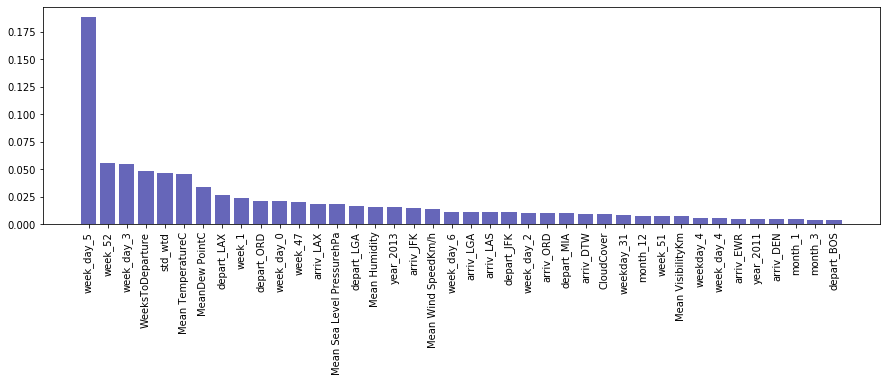

In [254]:
plt.figure(figsize=(15,4))

plt.bar(feature_names_ord, importances_ord, 
         color = 'darkblue', alpha= 0.6);
plt.xticks(rotation=90);

Avec une méthode de feature selection :

In [306]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

select = SelectFromModel(Lasso(0.1))
select.fit_transform(X_train,y_train)
selected_features = feature_names[select.get_support()]

In [307]:
X_train_select = X_train[selected_features]
X_test_select = X_test[selected_features]

On réapplique le modèle :  

In [309]:
from sklearn.model_selection import GridSearchCV

In [312]:
reg2 = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, 
                                            stop = 2000, 
                                            num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


grid = GridSearchCV(estimator = reg2, param_grid = param_grid, 
                          cv = 3, verbose = 1)

In [313]:
grid.fit(X_train_select, y_train);

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   7.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   9.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   9.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200, total=   8.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400, total=  10.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400, total=  10.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400, total=  10.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600, total=  11.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600, total=  11.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600, total=  11.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=  13.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800, total=  12.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800, total=  12.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  14.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  14.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, total=  14.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   4.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   6.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   7.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400, total=   6.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=   6.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600, total=   7.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=   9.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=  13.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=   9.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  15.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  19.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  17.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   7.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=  12.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=  12.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=  11.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=  10.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=  13.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=2

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=  13.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=  12.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=  16.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=  15.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=  16.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  19.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  19.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  18.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=  18.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=  18.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=  18.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1800, total=  20.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=  19.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800, total=  20.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, total=  20.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, total=  21.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=  20.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20,

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=   6.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200 
[CV]  bootstrap=True, max_dep

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400, total=   9.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  10.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800, total=  10.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800, total=  10.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800, total=  10.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, total=  10.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, total=  10.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, total=  10.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=  11.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=  11.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=  11.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  14.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_depth=3

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=  13.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total=  12.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200, total=  14.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200, total=  15.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200 
[CV]  bootstrap=True, max_de

KeyboardInterrupt: 

In [292]:
pred = predict(X_test_select)

In [293]:
scores = cross_val_score(reg2, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6224 +/- 0.0135


## Création de la pipeline finale

Dans cette pipeline, nous devrons :

- encoder la date en valeurs numériques (comme présenté dans la section ci-dessus) ;
- faire du `ordinal encoder` ou du `one hot encoding` sur les autres valeurs catégorielles pour obtenir des chiffres ;
- conserver les caractéristiques numériques telles quelles.

Ainsi, nous voulons effectuer trois processus différents sur différentes colonnes des données originales. Dans scikit-learn, nous pouvons utiliser `make_column_transformer` pour effectuer ce traitement.

### Préprocesseur

In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer


date_encoder = FunctionTransformer(_encoder_dates)
date_cols = ["DateOfDeparture"]

categorical_one_encoder = FunctionTransformer(get_dummy)
categorical_encoder = OrdinalEncoder()

categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (date_encoder, date_cols),
    (categorical_one_encoder, categorical_cols),
    remainder='passthrough')

In [18]:
preprocessor.fit_transform(X_train).shape

(8902, 52)

### Estimateur

In [19]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10

regressor_forests = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    max_features=max_features)

In [20]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(data_merger, preprocessor, regressor_forests)

## Validation 

Nous pouvons valider notre `pipeline` en utilisant `cross_val_score`. Ci-dessous, nous aurons spécifié `cv=5`, ce qui signifie que le fractionnement de la validation croisée `KFold` sera utilisé, avec 8 splits. La loss (l'erreur quadratique moyenne) est calculée pour chaque split. Le score de sortie sera un tableau de 5 scores de chaque KFold. La moyenne et l'écart-type des 5 scores sont affichés à la fin.

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline, X_train, y_train, cv=5, 
    scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print(f"RMSE: {np.mean(rmse_scores):.4f}\
      +/- {np.std(rmse_scores):.4f}")

RMSE: 0.6711      +/- 0.0172


Nous pouvons vérifier les importances des caractéristiques en utilisant la fonction [`sklearn.inspection.permutation_importances`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). 

Nous pouvons effectuer des `sklearn.inspection.permutation_importances` à n'importe quel stade du pipeline.